In [1]:
import base64
import requests

import subprocess
from getpass import getpass

password = getpass()
cmd = ["openssl", "enc", "-d", "-aes-256-cbc", "-in", "openai-key.enc", "-pass", f"pass:{password}"]
api_key = subprocess.run(cmd, capture_output=True, text=True).stdout.strip("\n")

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

 ········


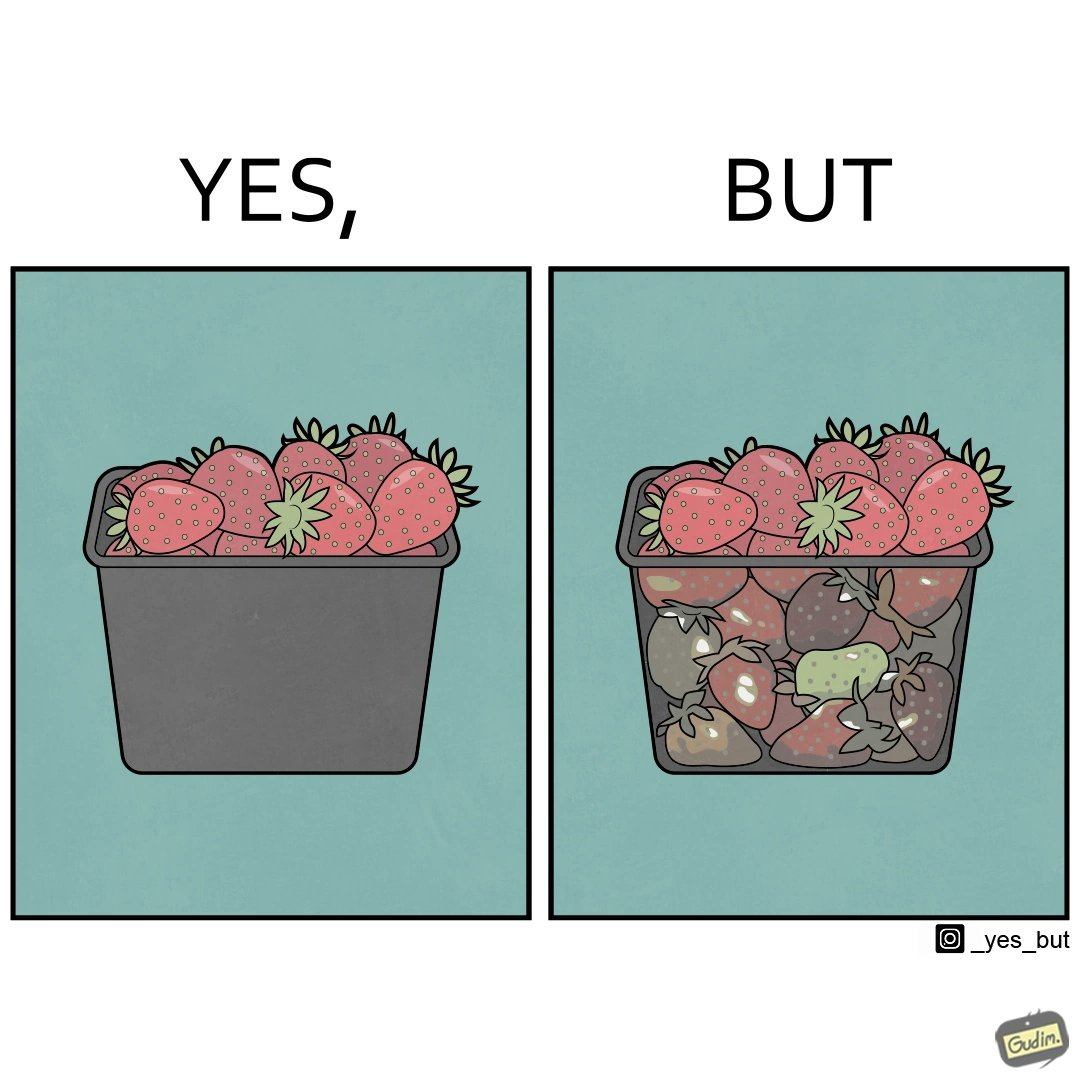

{'id': 'chatcmpl-9BldkWzjvEHH1cr60sfYLp7SeuQxz', 'object': 'chat.completion', 'created': 1712591764, 'model': 'gpt-4-1106-vision-preview', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Y'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 166, 'completion_tokens': 1, 'total_tokens': 167}, 'system_fingerprint': None}


In [4]:
prompt = '''You are an AI expert in detecting humour or satire. You detect and describe satire in user's image input and then classify it as either funny (Y) or not funny (N).
            ### IMPORTANT: Answer Y ONLY if the image is VERY obviously satirical (or funny).
            ###Output format: exactly only "Y" or "N"'''

def generate(image_path, verbose = False):
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    payload = {
      "model": "gpt-4-vision-preview",
      "messages": [
        {
            "role": "system",
            "content": [{"type": "text", "text": prompt}]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
                  "detail": "low"
              }
            }
          ]
        }
      ],
      "max_tokens": 256,
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload).json()
    if verbose:
        from PIL import Image
        image = Image.open(image_path)
        display(image)
        print(response)
    if "usage" not in response and "error" in response:
        raise Exception(response["error"]["message"])
    return response["usage"], response["choices"][0]["message"]["content"]

_ = generate("images/20240101_173254.jpg", True)

In [8]:
import os, json
from tqdm import tqdm
import random

## schema [{"image_path": <>, "prompt": <>, "usage": {"prompt_tokens": ...}}]
with open("gpt4-usages.json", "r") as f:
    usages = json.load(f)
    total_usage = sum(x["usage"]["total_tokens"] for x in usages)

outpath = "outputs/detection/gpt4-vision.json"
inpaths = ["images","yesbut_second_round","yesbut_second_round_negatives", "yesbut_third_round", "yesbut_third_round_negatives"]

try:
    with open(outpath, "r") as f:
        outputs = json.load(f)
except FileNotFoundError:
    print("starting from zero")
    outputs = {}

def get_pred(output):
    if not output:
        return ""
    return output[0]

def is_correct(pred, folder):
    if not pred:
        return False
    return (pred=="Y" and "negative" not in folder) or (pred=="N" and "negative" in folder)

current_usage = 0
total, correct, adhering, y = 0,0,0,0
files = sum(([os.path.join(folder, file) for file in os.listdir(folder) if file[-3:]=="jpg"] for folder in inpaths),[])   
random.Random(42).shuffle(files)
pbar = tqdm(files)
for filepath in pbar:
    folder,file = filepath.split('/')
    if filepath in outputs and outputs[filepath]:
        total+=1
        pred = get_pred(outputs[filepath])
        correct += 1 if is_correct(pred,folder) else 0
        adhering += 1 if pred in ["Y", "N"] else 0
        y += 1 if pred=="Y" else 0
        pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage, "folder": folder, "total": total, "accuracy": correct/total, "adherance": adhering/total, "y%": y/adhering if adhering>0 else 0})
        continue
    try:
        usage, output = generate(filepath)
    except Exception as e:
        print("Caught exception: ", str(e))
        print("Could not do: ",filepath)
        usage = {'prompt_tokens': 0, 'completion_tokens': 0, 'total_tokens': 0}
        output = ""

    outputs[filepath] = output
    with open(outpath, "w") as f:
        json.dump(outputs, f, indent=4)

    usages.append({"image_path":filepath, "prompt": prompt, "usage": usage})
    with open("gpt4-usages.json", "w") as f:
        json.dump(usages, f, indent=2)
    
    current_usage+=usage["total_tokens"]
    total_usage+=usage["total_tokens"]

    total+=1
    pred = get_pred(outputs[filepath])
    correct += 1 if is_correct(pred,folder) else 0
    adhering += 1 if pred in ["Y", "N"] else 0
    y += 1 if pred=="Y" else 0
    pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage, "folder": folder, "total": total, "accuracy": correct/total, "adherance": adhering/total, "y%": y/adhering if adhering>0 else 0})

with open(outpath, "w") as f:
    json.dump(outputs, f, indent=4)  

  1%|▏            | 33/2547 [01:51<2:21:31,  3.38s/it, current_usage=5344, total_usage=8e+5, folder=yesbut_third_round_negatives, total=33, accuracy=0.545, adherance=1, y%=0.576]


KeyboardInterrupt: 

In [ ]:
# whyfunny: 53930
# punchline: 63560
# left: ~60000
# right: ~60000

In [ ]:
positives - 1084:
    1. original - 283
    2. second_round - 302
    3. third_round - 499
negatives - 1463:
    1. second_round - 547
    2. third_round - 916